# Initialization

In [1]:
import pandas as pd
import numpy as np
import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

# Font
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
mpl.rc('font', **font)

# Style
plt.style.use(['science'])

# Defining Reaction Mechanism

## Mechanism II - Marinov + Mevel

In [3]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

mevel_species = ct.Species.listFromFile('mevel_ethanol_mechanism.cti')
mevel_reactions = ct.Reaction.listFromFile('mevel_ethanol_mechanism.cti')

new_species = []
new_reactions = []

# Filter species
for specie in mevel_species:
    # Include all nitrogen compounds except for N2
    if 'N' in specie.composition and specie.composition != {'N':2}: new_species.append(specie)

new_species_names = {specie.name for specie in new_species}
# print('N based species: {0}'.format(', '.join(name for name in new_species_names)))

marinov_mevel_species = marinov_species + new_species
marinov_mevel_species_names = {specie.name.upper() for specie in marinov_mevel_species}

# Filter reactions, keeping only those that only involve the selected species
# print('\nReactions:')
for R in mevel_reactions:
    if any(reactant in new_species_names for reactant in R.reactants) or any(product in new_species_names for product in R.products):
        # for reactant in R.reactants:
            # if reactant not in marinov_mevel_species_names:
                # print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        # for product in R.products:
            # if product not in marinov_mevel_species_names:
                # print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in marinov_mevel_species_names for reactant in R.reactants):
            if all(product in marinov_mevel_species_names for product in R.products):
                new_reactions.append(R)
                # print('Accepted reaction:', R.equation)
# print('\n')

marinov_mevel_species = marinov_species + new_species
marinov_mevel_reactions = marinov_reactions + new_reactions

marinov_mevel_gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=marinov_mevel_species,
    reactions=marinov_mevel_reactions
)

print('Number of species:', marinov_mevel_gas.n_species)
print('Number of reactions:', marinov_mevel_gas.n_reactions)

Number of species: 93
Number of reactions: 664


# Thermodynamic Properties

## Calculation in Equilibrium - Constant Temperature and Pressure

In [4]:
# Define the reactor temperature and pressure
def enthalpy(gas, T, P, phi):
    # gas: Cantera Solution
    # T: temperature in K
    # P: pressure in Pa
    # phi: equivalence ratio
    
    # gas.enthalpy_mass: J/kg
    
    # print(T, phi)
    
    # Set initial state
    gas.TP = T, P
    gas.set_equivalence_ratio(phi, fuel='c2h5oh', oxidizer='N2O')
    
    # Calculate equilibrium under constant temperature and pressure
    gas.equilibrate('TP')
    
    return gas.enthalpy_mass

In [5]:
%timeit enthalpy(marinov_mevel_gas, T=1500, P=35*1e5, phi=1)

1.06 ms ± 32.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
T_mesh = np.linspace(1000, 4000, 50)
phi_mesh = np.linspace(0.5, 2.0, 50)
T_mesh_grid, phi_mesh_grid = np.meshgrid(T_mesh, phi_mesh)

H = np.zeros(T_mesh_grid.shape)

for i in range(T_mesh_grid.shape[0]):
    for j in range(T_mesh_grid.shape[1]):
        H[i, j] = enthalpy(marinov_mevel_gas, T_mesh_grid[i, j], 35*1e5, phi_mesh_grid[i, j])

# H = np.vectorize(enthalpy)(marinov_mevel_gas, T_mesh_grid, 35*1e5, phi_mesh_grid)

## Plots

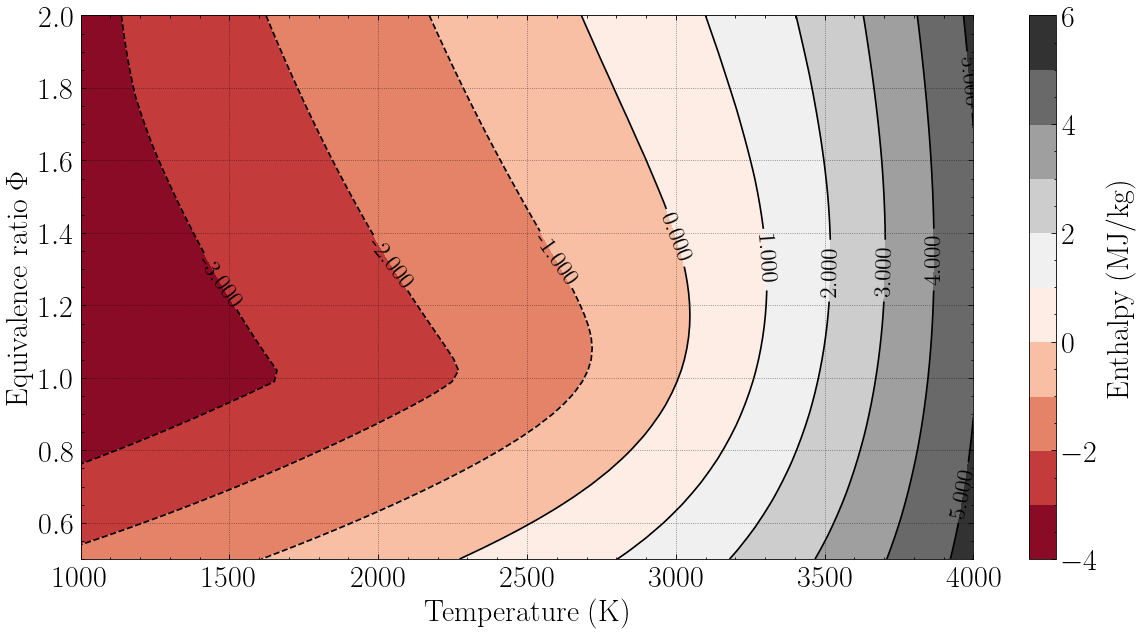

In [53]:
plt.figure(figsize=(12,6))
contours = plt.contour(T_mesh_grid, phi_mesh_grid, H/1e6, 10, colors='black')
plt.clabel(contours, inline=True, fontsize=14)
plt.contourf(T_mesh_grid, phi_mesh_grid, H/1e6, 10, cmap='RdGy')
plt.colorbar().set_label('Enthalpy (MJ/kg)')
plt.ylabel(r'Equivalence ratio $\Phi$')
plt.xlabel('Temperature (K)')
plt.savefig('enthalpy_contour.pdf')
plt.show()